In [1]:
import math
import numpy as np
def _gaussian_schedule(t, T, num_tasks, mu_exp=0.5, sigma=0.5, min_prob=False):
    '''
    Gaussian schedule for task sampling.
    mu_exp: exponent for the mean, typically 1.0. Move faster at the beginning: < 1.0. Move slower at the beginning: > 1.0
    sigma: standard deviation of the Gaussian distribution
    min_prob: minimum probability for each task
    '''
    # Move mean from 0 to (num_tasks-1) as time progresses, Use sqrt(t / T) to boost the the speed at the beginning
    mu = (t / T) ** mu_exp * (num_tasks - 1)

    if isinstance(min_prob, bool):
        p_min = 2 / (num_tasks * (num_tasks + 1)) if min_prob else 0.0
    elif isinstance(min_prob, float):
        p_min = min_prob
    else:
        raise ValueError("min_prob should be either a boolean or a float")

    # Calculate unnormalized probabilities using Gaussian PDF
    unnormalized_probs = {}
    for i in range(num_tasks):
        # Calculate PDF of Gaussian for task i
        exponent = -((i - mu) ** 2) / (2 * sigma ** 2)
        unnormalized_probs[i] = math.exp(exponent)
        unnormalized_probs[i] = max(unnormalized_probs[i], p_min)

    total = sum(unnormalized_probs.values())
    return {i: prob / total for i, prob in unnormalized_probs.items()}

def _cosine_schedule(t, T, num_tasks, tau=1.0):
    total = num_tasks * (num_tasks + 1) / 2.0
    i = np.arange(num_tasks, dtype=float)
    early = (num_tasks - i) / num_tasks
    late  = (i + 1) / num_tasks
    alpha = 0.5 * (1 + math.cos(math.pi * t / T))
    probs = {i: alpha * early[i] + (1 - alpha) * late[i] for i in range(num_tasks)}
    # Enforce symmetric floor equal to the minimum probability in early/late.
    p_min = 2 / (num_tasks * (num_tasks + 1))
    for i in range(num_tasks):
        probs[i] = max(probs[i], p_min)
    norm = sum(probs.values())
    return {i: probs[i] / norm for i in probs}

num_tasks: 4
mu: 0.25, sigma: 0.75


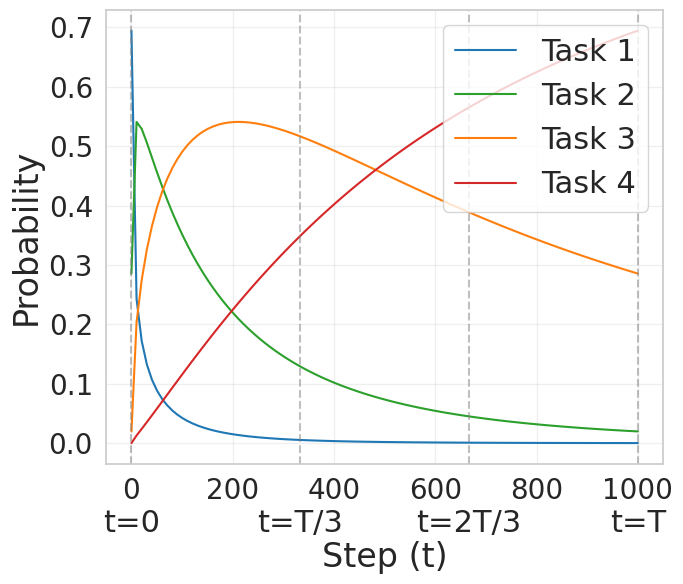

Probabilities at specific time points:
t=0: Task 0: 0.881  Task 1: 0.119  Task 2: 0.000  Task 3: 0.000  
t=T/3: Task 0: 0.002  Task 1: 0.274  Task 2: 0.692  Task 3: 0.032  
t=2T/3: Task 0: 0.000  Task 1: 0.012  Task 2: 0.544  Task 3: 0.444  
t=T: Task 0: 0.000  Task 1: 0.000  Task 2: 0.119  Task 3: 0.881  
mu: 0.5, sigma: 0.5


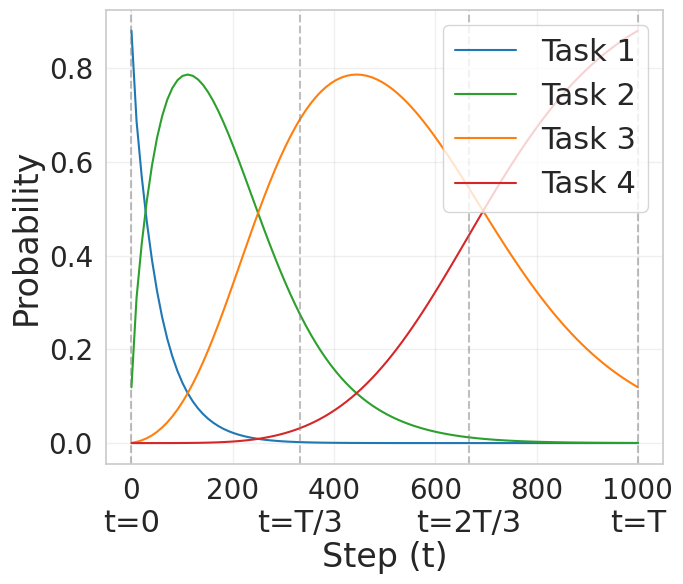

Probabilities at specific time points:
t=0: Task 0: 0.881  Task 1: 0.119  Task 2: 0.000  Task 3: 0.000  
t=T/3: Task 0: 0.002  Task 1: 0.274  Task 2: 0.692  Task 3: 0.032  
t=2T/3: Task 0: 0.000  Task 1: 0.012  Task 2: 0.544  Task 3: 0.444  
t=T: Task 0: 0.000  Task 1: 0.000  Task 2: 0.119  Task 3: 0.881  
mu: 0.75, sigma: 0.25


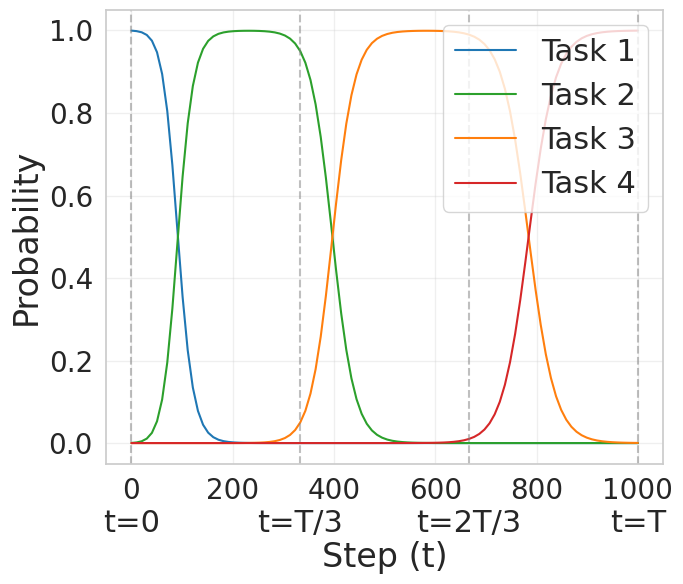

Probabilities at specific time points:
t=0: Task 0: 0.881  Task 1: 0.119  Task 2: 0.000  Task 3: 0.000  
t=T/3: Task 0: 0.002  Task 1: 0.274  Task 2: 0.692  Task 3: 0.032  
t=2T/3: Task 0: 0.000  Task 1: 0.012  Task 2: 0.544  Task 3: 0.444  
t=T: Task 0: 0.000  Task 1: 0.000  Task 2: 0.119  Task 3: 0.881  


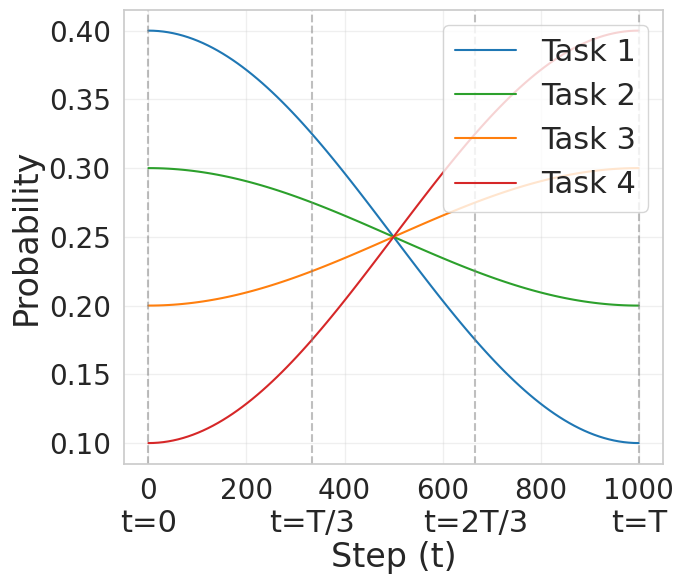

Probabilities at specific time points:
t=0: Task 0: 0.881  Task 1: 0.119  Task 2: 0.000  Task 3: 0.000  
t=T/3: Task 0: 0.002  Task 1: 0.274  Task 2: 0.692  Task 3: 0.032  
t=2T/3: Task 0: 0.000  Task 1: 0.012  Task 2: 0.544  Task 3: 0.444  
t=T: Task 0: 0.000  Task 1: 0.000  Task 2: 0.119  Task 3: 0.881  


In [13]:
# Use seaborn for better aesthetics
import seaborn as sns
sns.set(style="whitegrid")
# sns.set_theme()
axis_label_size = 24
tick_label_size = 20
legend_font_size = 22
def visualize_gaussian_schedule(T=1000, num_tasks=4, num_steps=100, scheduler=_gaussian_schedule):
    """
    Visualize how task probabilities change over time using the Gaussian schedule.
    
    Parameters:
    - T: Total time duration (default: 100)
    - num_tasks: Number of tasks (default: 4)
    - num_steps: Number of time points to plot (default: 100)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Generate time points
    time_points = np.linspace(0, T, num_steps)
    
    # Calculate probabilities for each task at each time point
    probabilities = []
    for i in range(num_tasks):
        task_probs = []
        for t in time_points:
            task_probs.append(scheduler(t, T, num_tasks)[i])
        probabilities.append(task_probs)
    
    # Create visualization
    plt.figure(figsize=(7, 6))
    
    # Line plot
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    for i in range(num_tasks):
        plt.plot(time_points, probabilities[i], label=f'Task {i+1}', color=colors[i])
    
    # plt.title('Task Probabilities over Time using Schedule')
    plt.xlabel('Step (t)', fontsize=axis_label_size, labelpad=26)
    plt.ylabel('Probability', fontsize=axis_label_size)
    plt.tick_params(axis='both', which='major', labelsize=tick_label_size)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=legend_font_size, loc='upper right')
    
    # Add reference lines at key points
    special_points = [0, T/3, 2*T/3, T]
    special_labels = ['t=0', 't=T/3', 't=2T/3', 't=T']
    
    for point, label in zip(special_points, special_labels):
        plt.axvline(x=point, linestyle='--', color='gray', alpha=0.5)
        plt.text(point, -0.1, label, transform=plt.gca().get_xaxis_transform(), 
                ha='center', va='top', fontsize=axis_label_size - 2)
    
    plt.tight_layout()
    plt.show()
    
    # Print the probabilities at key time points
    print("Probabilities at specific time points:")
    for point, label in zip(special_points, special_labels):
        probs = _gaussian_schedule(point, T, num_tasks)
        print(f"{label}:", end=" ")
        for i in range(num_tasks):
            print(f"Task {i}: {probs[i]:.3f}", end="  ")
        print()
        
from functools import partial
for num_tasks in [4]:
    print(f"num_tasks: {num_tasks}")
    for mu, sigma in [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]:
        print(f"mu: {mu}, sigma: {sigma}")
        visualize_gaussian_schedule(num_tasks=num_tasks, scheduler=partial(_gaussian_schedule, mu_exp=mu, sigma=sigma, min_prob=False))
# visualize_gaussian_schedule(scheduler=partial(_gaussian_schedule, ))
visualize_gaussian_schedule(scheduler=_cosine_schedule)


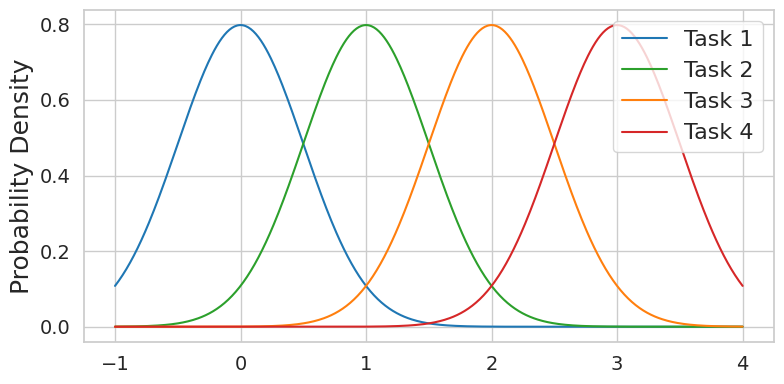

In [19]:
# Draw 4 gaussian distributions with the same variance and different means, \mu_0=0, \mu_1=1, \mu_2=2, \mu_3=3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

axis_label_size = 18
tick_label_size = 14
legend_font_size = 16

colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
# Means and shared standard deviation
means = [0, 1, 2, 3]
std = 0.5  # standard deviation
x = np.linspace(-1, 4, 500)

# Plotting
plt.figure(figsize=(8, 4))
for mu in means:
    y = norm.pdf(x, loc=mu, scale=std)
    plt.plot(x, y, label=f'Task {mu + 1}', color=colors[means.index(mu)])

# plt.title('Gaussian Distributions of Tasks')
# plt.xlabel('x')
plt.tick_params(axis='both', which='major', labelsize=tick_label_size)
plt.ylabel('Probability Density', fontsize=axis_label_size)
plt.legend(fontsize=legend_font_size, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()